In [1]:
# ------------------------------ Packages & Files ------------------------------
from pathlib import Path

import copy
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn.objects as so
from plotly.subplots import make_subplots

import ipywidgets as widgets
from IPython.display import display, HTML

from ppa_analysis import user_inputs, advanced_settings, hybrid, import_data,\
    bill_calc, battery, firming_contracts, load_flex, helper_functions, charts

from sunspot_bill_calculator import bill_calculator, convert_network_tariff_to_retail_tariff, add_other_charges_to_tariff

INFO: Using Python-MIP package version 1.15.0


In [2]:
# ------------------------------ Initialise the input collector ----------------
input_collector = user_inputs.launch_input_collector()

/Users/elliekallmier/Desktop/RA_Work/247/247_ppa/ppa_analysis
data_caches/yearly_data_files


Dropdown(description='Year:', options=('2020', '2021'), value='2020')

Dropdown(description='Generator region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load data file:', options=('(57) Sewerage treatment FN.csv', '(54) Office building FN.cs…

SelectMultiple(description='Generators:', index=(0, 1, 2, 3), options=('CSPVPS1: PHOTOVOLTAIC FLAT PANEL', 'CO…

Dropdown(description='Contract type:', options=('Pay as Produced', 'Pay as Consumed', 'Shaped', 'Baseload', '2…

Dropdown(description='Firming contract type:', options=('Wholesale exposed', 'Partially wholesale exposed', 'R…

Dropdown(description='Settlement period:', options=('Y', 'M', 'Q'), value='Y')

BoundedFloatText(value=100.0, description='Contract amount (%):', max=1000.0)

FloatText(value=100.0, description='Strike price ($/MW/h):')

FloatText(value=35.0, description='LGC buy price ($/MW/h):')

FloatText(value=20.0, description='LGC sell price ($/MW/h):')

FloatText(value=25.0, description='Short fall penalty ($/MW/h):')

BoundedFloatText(value=85.0, description='Guaranteed percentage (%):')

FloatText(value=0.0, description='Floor price ($/MW/h):')

FloatText(value=65.0, description='Excess price ($/MW/h):')

BoundedFloatText(value=1.0, description='Indexation (%):')

Dropdown(description='Index period:', options=('Y',), value='Y')

Dropdown(description='Redefine period:', index=2, options=('Y', 'Q', 'M'), value='M')

BoundedFloatText(value=90.0, description='Matching percentile:')

FloatText(value=300.0, description='Exposure upper bound ($/MW/h):')

FloatText(value=20.0, description='Exposure lower bound ($/MW/h):')

Dropdown(description='Time series interval:', options=('60',), value='60')

Dropdown(description='Generator data set:', options=('GenCost 2018 Low',), value='GenCost 2018 Low')

In [3]:
generator_data_editor = user_inputs.launch_generator_data_editor(input_collector)

Output()

In [4]:
tariff_collector = user_inputs.tariff_options_collector(input_collector)

if input_collector['firming_contract_type'].value == 'Retail':
    extra_charges_collector = user_inputs.launch_extra_charges_collector()
else:
    extra_charges_collector = {}

Dropdown(description='Tariff name:', options=('ELTOUDT1 ToU Demand East', 'ELTOUDT2 ToU Demand East', 'ELTOUDT…

In [5]:
# ------------------- Unpack LCOE Inputs -------------------------

# Calculate LCOE from user inputs/predetermined values
# Function takes in the  generator LCOE info dictionary, and calculates LCOE
# for only one generator with each call.
# Returns LCOE value in $/MW
def calculate_lcoe(
    generator_info:dict[str:object]        
) -> float:
    
    # Baseline assumptions:
    discount_rate = advanced_settings.DISCOUNT_RATE

    capital = generator_info['capital'].value*1000
    construction_years = generator_info['construction_time'].value
    economic_life = generator_info['economic_life'].value
    fixed_om = generator_info['fixed_om'].value
    variable_om = generator_info['variable_om'].value
    capacity_factor = generator_info['capacity_factor'].value

    first_capital_sum = (capital*(1+discount_rate)**construction_years * discount_rate * (1+discount_rate)**economic_life) / (((1+discount_rate)**economic_life)-1)/(8760*capacity_factor)

    op_and_main = variable_om * ((fixed_om*1000)/(8760*capacity_factor))

    lcoe = first_capital_sum + op_and_main

    return lcoe


# ----- Fetch inputs and set up info_dict data to pass to later functions:
def get_all_lcoes(
        generator_data_editor:dict[str:dict[str:object]]
) -> dict[str:float]:
    all_generator_lcoes = {}
    for gen, gen_info in generator_data_editor.items():
        if gen != 'out':
            gen_lcoe = calculate_lcoe(gen_info)
            all_generator_lcoes[gen] = gen_lcoe
    
    return all_generator_lcoes


In [6]:
# Maybe this function is where the load gets pulled in, all the other data collecting
# functions get called etc

def collect_and_combine_data(
        input_collector:dict,
        tariff_collector:dict,
        extra_charges_collector:dict
) -> pd.DataFrame:    
    # ----------------------------- Unpack user input ------------------------------
    year_to_load_from_cache = input_collector['year'].value
    year_to_load = int(year_to_load_from_cache)
    GENERATOR_REGION = input_collector['generator_region'].value
    LOAD_REGION = input_collector['load_region'].value
    generators = list(input_collector['generators'].value)

    # ------------------- Get Load Data --------------------
    # if using preset data, use these hard coded values:
    LOAD_DATA_DIR = 'data_caches/c_and_i_customer_loads'
    load_filename = input_collector['load_data_file'].value
    filepath = LOAD_DATA_DIR + '/' + load_filename
    LOAD_DATETIME_COL_NAME = 'TS'
    LOAD_COL_NAME = 'Load'
    DAY_FIRST = True

    # Units are definitely a question.
    load_data, start_date, end_date = import_data.get_load_data(filepath, LOAD_DATETIME_COL_NAME, LOAD_COL_NAME, DAY_FIRST)
    load_data = load_data / 1000    # convert to MWh
    load_data = load_data[
        (load_data.index >= f'{year_to_load}-01-01 00:00:00') & 
        (load_data.index < f'{year_to_load+1}-01-01 00:00:00')
    ]

    # else: TODO add another option here if users want to load in their own data

    # ----------------------------- Get Generation Data ----------------------------
    gen_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'gen_data_{year_to_load_from_cache}.parquet'
    )
    gen_data = import_data.get_preprocessed_gen_data(
        gen_data_file, [GENERATOR_REGION]
    )
    gen_data = gen_data[generators]

    # --------------------------- Get Emissions Data -------------------------------
    emissions_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'emissions_data_{year_to_load_from_cache}.parquet'
    )
    emissions_intensity = import_data.get_preprocessed_avg_intensity_emissions_data(
        emissions_data_file, [LOAD_REGION, GENERATOR_REGION]
    )

    # ------------------------ Get Wholesale Price Data ----------------------------
    price_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'price_data_{year_to_load_from_cache}.parquet'
    )
    price_data = import_data.get_preprocessed_price_data(
        price_data_file, [LOAD_REGION, GENERATOR_REGION]
    )

    combined_data = pd.concat([load_data, gen_data, price_data, emissions_intensity], axis='columns')

    FIRMING_CONTRACT_TYPE = input_collector['firming_contract_type'].value
    EXPOSURE_BOUND_UPPER = input_collector['exposure_upper_bound'].value
    EXPOSURE_BOUND_LOWER = input_collector['exposure_lower_bound'].value
    RETAIL_TARIFF_DETAILS = {}

    if input_collector['firming_contract_type'].value == 'Retail':
        selected_tariff_name = tariff_collector['tariff_name'].value
        all_tariffs = helper_functions.read_json_file(advanced_settings.COMMERCIAL_TARIFFS_FN)
        all_tariffs = all_tariffs[0]['Tariffs']
        for tariff in all_tariffs:
            if tariff['Name'] == selected_tariff_name:
                selected_tariff = copy.deepcopy(tariff)

        extra_charges = helper_functions.format_other_charges(extra_charges_collector)
        RETAIL_TARIFF_DETAILS = add_other_charges_to_tariff(selected_tariff, extra_charges)

    # Add the firming details:
    combined_data = firming_contracts.choose_firming_type(
        FIRMING_CONTRACT_TYPE, combined_data, [LOAD_REGION], EXPOSURE_BOUND_UPPER, EXPOSURE_BOUND_LOWER, RETAIL_TARIFF_DETAILS
    )

    return combined_data

In [7]:
# At the moment: this is all assuming the use of sample load data stored with the tool
gen_info = get_all_lcoes(generator_data_editor)
combined_data = collect_and_combine_data(input_collector, tariff_collector, extra_charges_collector)

# Had an issue with first row containing a few NaN values causing problems for 
# the firming column addition. But just using dropna without checks not a safe bet
# necessarily...
combined_data = combined_data.dropna(how='any', axis='rows')

Some missing data found. Filled with zeros.



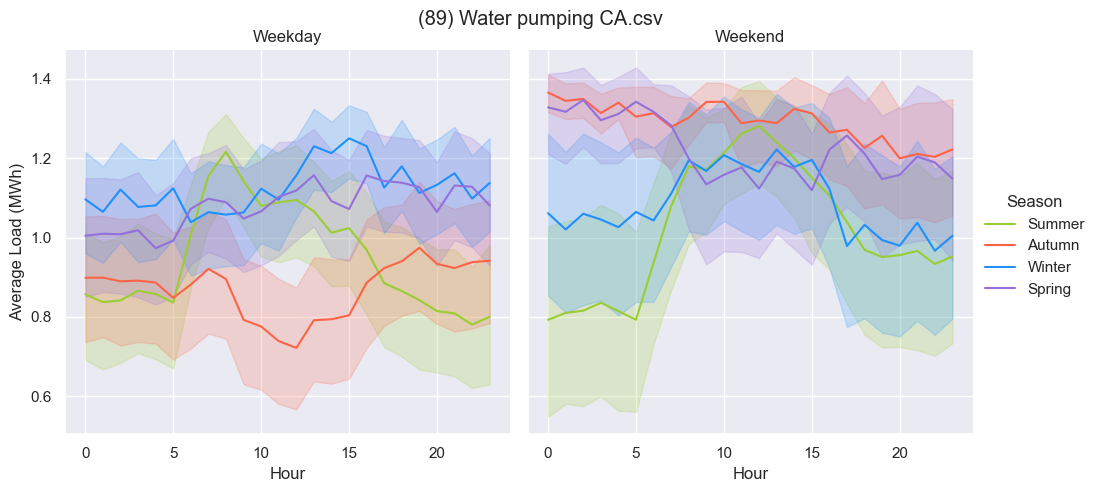

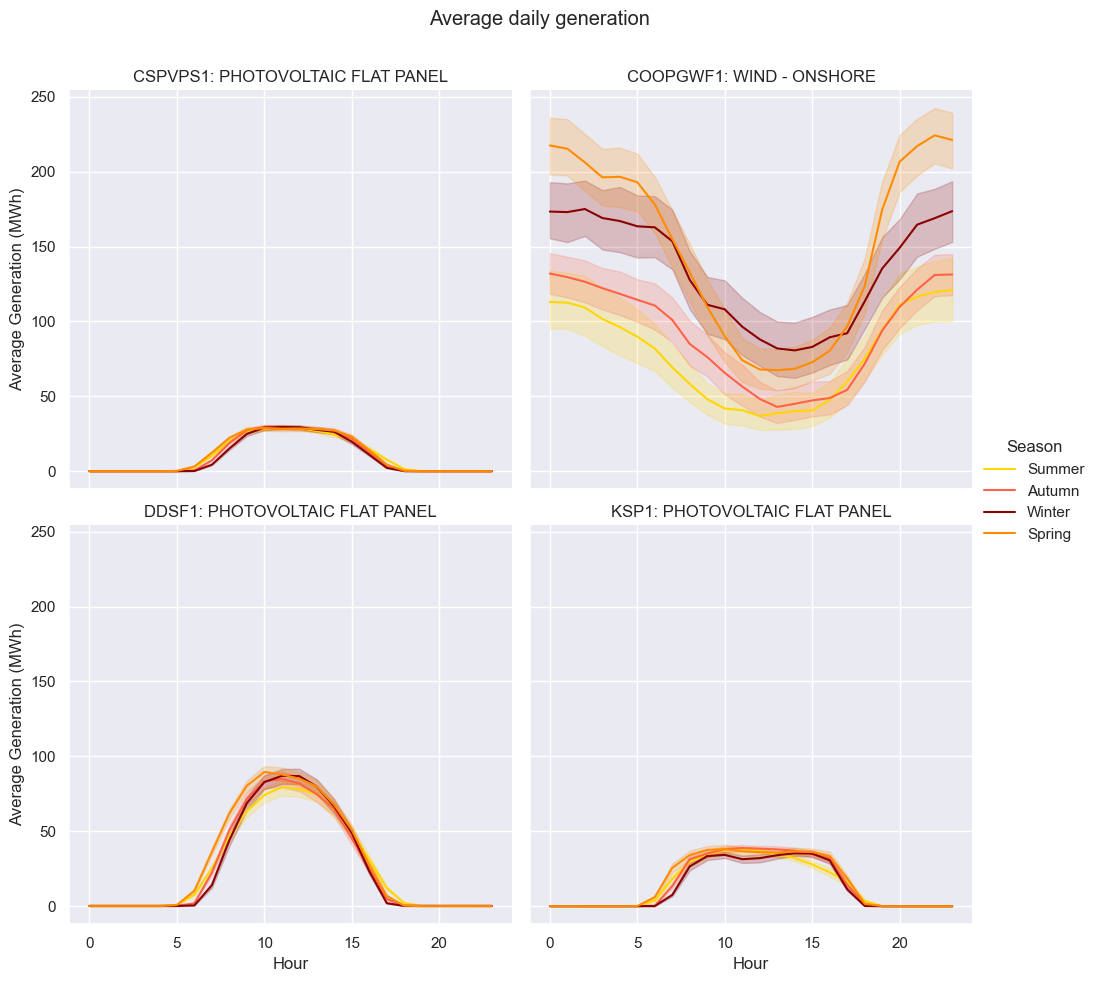

In [8]:
# Characteristic charts:
import seaborn as sns
import matplotlib.pyplot as plt

charts.plot_avg_seasonal_load(combined_data, input_collector['load_region'].value, input_collector['load_data_file'].value)
charts.plot_avg_seasonal_generation(combined_data, input_collector['load_region'].value, [gen for gen in generator_data_editor.keys() if gen != 'out'])

In [9]:
# Now calculate the hybrid percentage here:
opt_hybrid, percentages = hybrid.create_hybrid_generation(
    input_collector['contract_type'].value, 
    input_collector['redefine_period'].value,  
    input_collector['contract_amount'].value, 
    combined_data, 
    input_collector['load_region'].value, 
    gen_info, 
    input_collector['time_series_interval'].value, 
    input_collector['matching_percentile'].value
)

combined_data['Contracted Energy'] = opt_hybrid['Contracted Energy'].copy()
combined_data['Hybrid'] = opt_hybrid['Hybrid'].copy()
combined_data['Delivered Hybrid'] = np.minimum(
    combined_data['Contracted Energy'], combined_data['Hybrid']
)

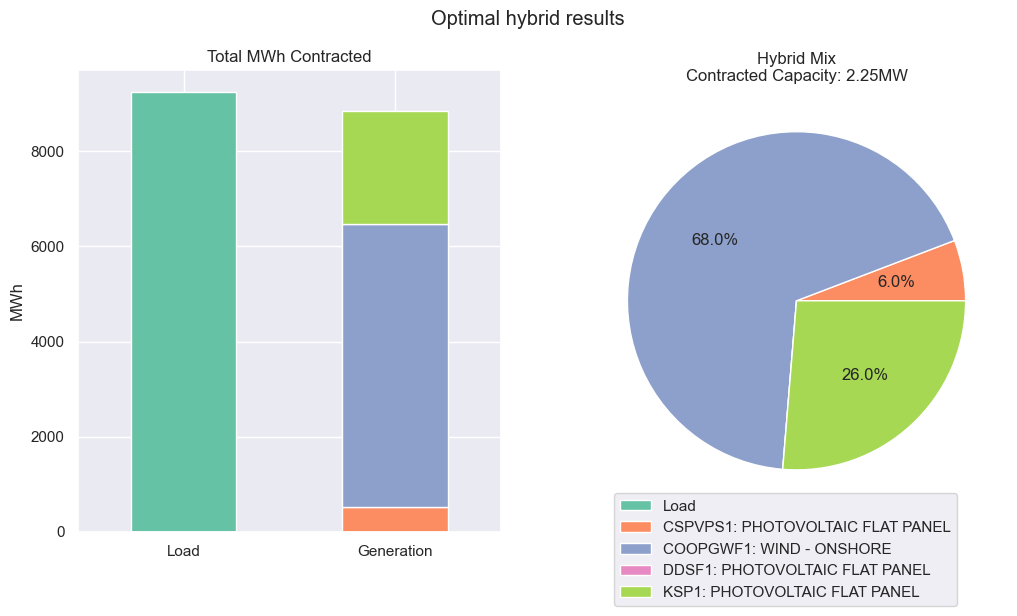

In [11]:
generator_capacities = {
    key : generator_data_editor[key]['capacity'].value for key in generator_data_editor if key != 'out'
}
charts.plot_hybrid_results(combined_data, percentages, generator_capacities)


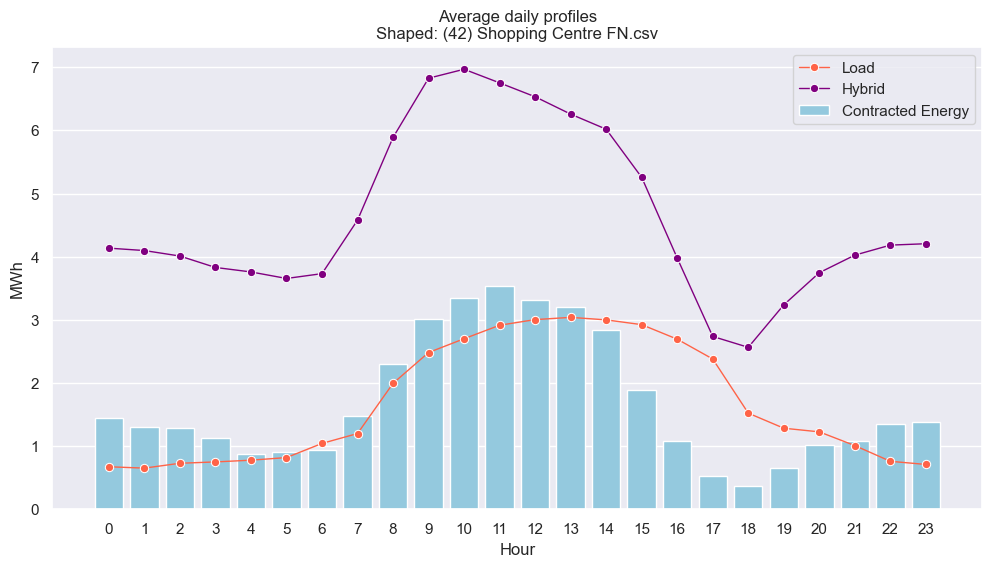

In [10]:
charts.plot_contract_samples(combined_data,input_collector['load_data_file'].value,input_collector['contract_type'].value, ['Load'])

In [11]:
tariff_details = {
    'Network' : helper_functions.get_selected_tariff(tariff_collector, extra_charges_collector, False),
    'Retail' : helper_functions.get_selected_tariff(tariff_collector, extra_charges_collector)
}

bill = bill_calc.calculate_bill(
    volume_and_price=combined_data, 
    settlement_period=input_collector['settlement_period'].value, 
    contract_type=input_collector['contract_type'].value, 
    firming_type=input_collector['firming_contract_type'].value,
    tariff_details=tariff_details,
    load_region=input_collector['load_region'].value, 
    strike_price=input_collector['strike_price'].value, 
    lgc_buy_price=input_collector['lgc_buy_price'].value, 
    lgc_sell_price=input_collector['lgc_sell_price'].value, 
    shortfall_penalty=input_collector['shortfall_penalty'].value, 
    guaranteed_percent=input_collector['guaranteed_percent'].value, 
    excess_price=input_collector['excess_price'].value, 
    indexation=input_collector['indexation'].value, 
    index_period=input_collector['index_period'].value, 
    floor_price=input_collector['floor_price'].value
)

wholesale_bill = bill_calc.calculate_wholesale_bill(
    df=combined_data,
    settlement_period=input_collector['settlement_period'].value,
    load_region=input_collector['load_region'].value,
    lgc_buy_price=input_collector['lgc_buy_price'].value
)

In [39]:
small_bill = bill[['PPA Final Cost', 'Firming Costs', 'Network Costs', 'Revenue from on-sold RE', 'Revenue from excess LGCs', 'Cost of shortfall LGCs', 'Shortfall Payments Received', 'Total']].copy()

In [40]:
small_bill_with_wholesale = small_bill.copy()
small_bill_with_wholesale['Wholesale Total'] = wholesale_bill['Total'].copy()
small_bill_with_wholesale['Wholesale Total'] += small_bill_with_wholesale['Network Costs']

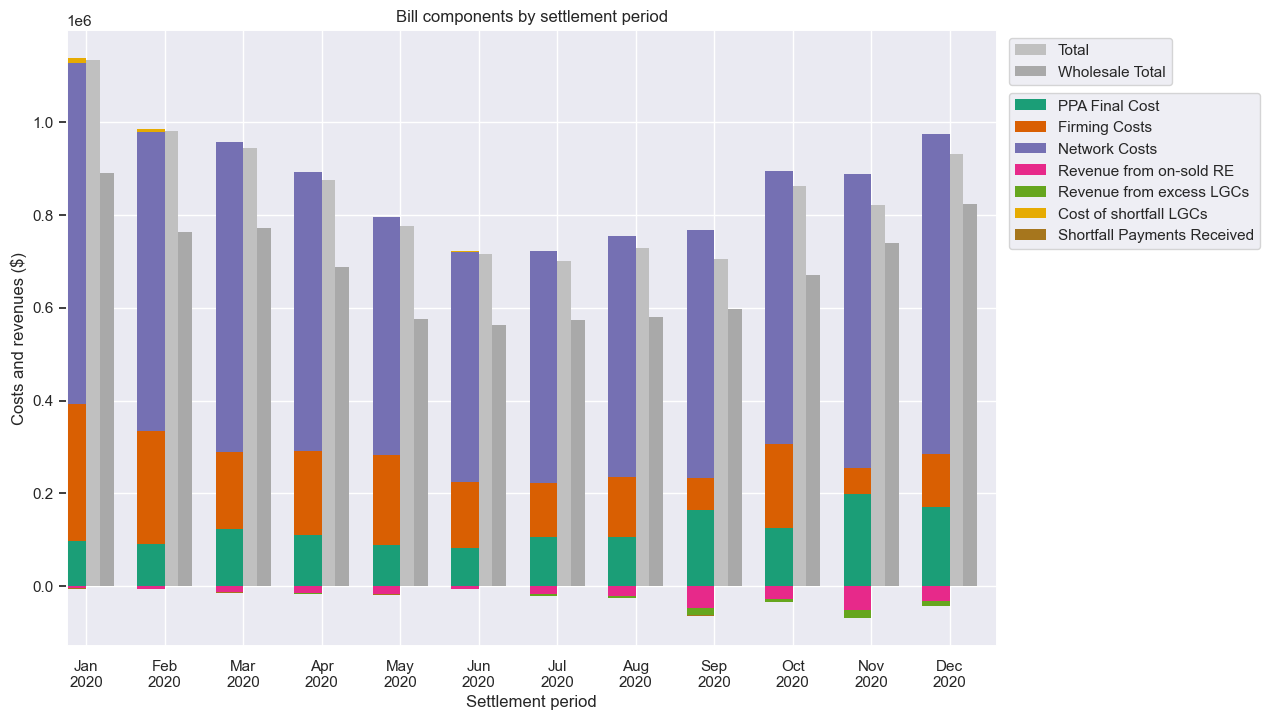

In [41]:
charts.plot_bill_components(small_bill_with_wholesale.astype(float), input_collector['settlement_period'].value)

In [37]:
small_bill_with_wholesale = small_bill_with_wholesale.drop(columns=['Wholesale Total'])
charts.plot_cashflow(small_bill_with_wholesale.astype(float))

## Add a behind-the-meter battery:

In [18]:
battery_input_collector = user_inputs.launch_battery_input_collector()

FloatText(value=1.0, description='Rated power capacity (MW):')

FloatText(value=2.0, description='Battery size (MWh):')

In [19]:
# Battery
rated_power_capacity = battery_input_collector['rated_power_capacity'].value
size_in_mwh = battery_input_collector['size_in_mwh'].value

with_a_battery = battery.run_battery_optimisation(
    df=combined_data,
    load_col_to_use='Load', # Default - field may not even be useful long-term
    region=input_collector['load_region'].value,
    rated_power_capacity=rated_power_capacity,
    size_in_mwh=size_in_mwh
)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05


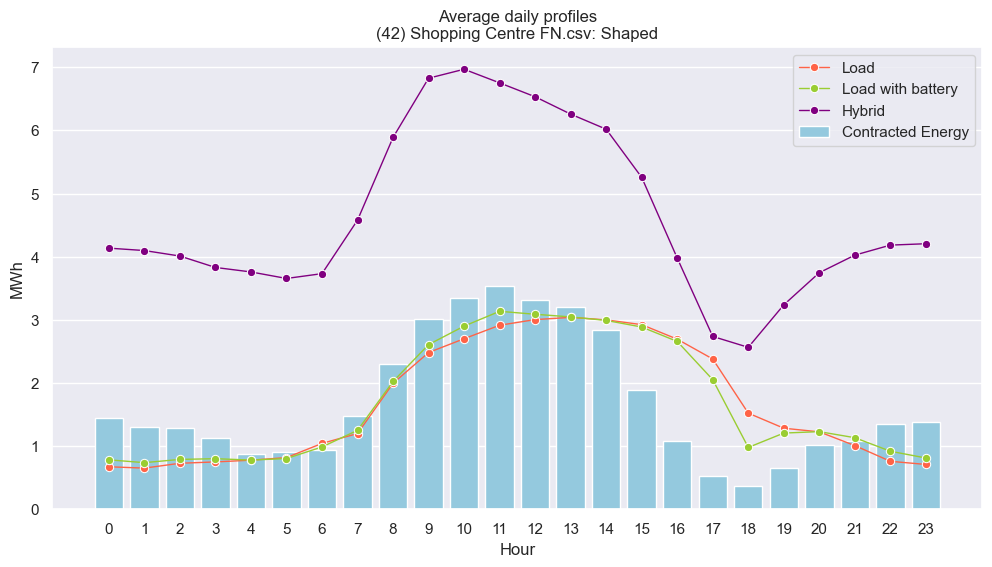

In [22]:
charts.plot_contract_samples(combined_data,input_collector['contract_type'].value,input_collector['load_data_file'].value,['Load', 'Load with battery'])

In [23]:
# Load Flex
flex_input_collector = user_inputs.launch_flex_input_collector()

Dropdown(description='Flexiblity rating:', options=('Very Low', 'Low', 'Medium', 'High', 'Very High'), value='…

FloatText(value=0.0, description='Raise price ($/MWh):')

FloatText(value=0.0, description='Lower price ($/MWh):')

FloatText(value=0.01, description='Ramp up penalty ($/MWh):')

FloatText(value=0.01, description='Ramp down penalty ($/MWh):')

In [24]:
combined_data = helper_functions.get_weekends(combined_data, input_collector['load_region'].value)

In [25]:
flex_rating = flex_input_collector['flex_rating'].value
raise_price = flex_input_collector['raise_price'].value
lower_price = flex_input_collector['lower_price'].value
ramp_up = flex_input_collector['ramp_up'].value
ramp_down = flex_input_collector['ramp_down'].value

with_load_flex = load_flex.daily_load_shifting(
    df=combined_data,
    flexibility_rating=flex_rating,
    load_region=input_collector['load_region'].value,
    raise_price=raise_price,
    lower_price=lower_price,
    ramp_up_price=ramp_up,
    ramp_down_price=ramp_down
)

combined_data['Load with flex'] = with_load_flex['Load with flex'].copy()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05

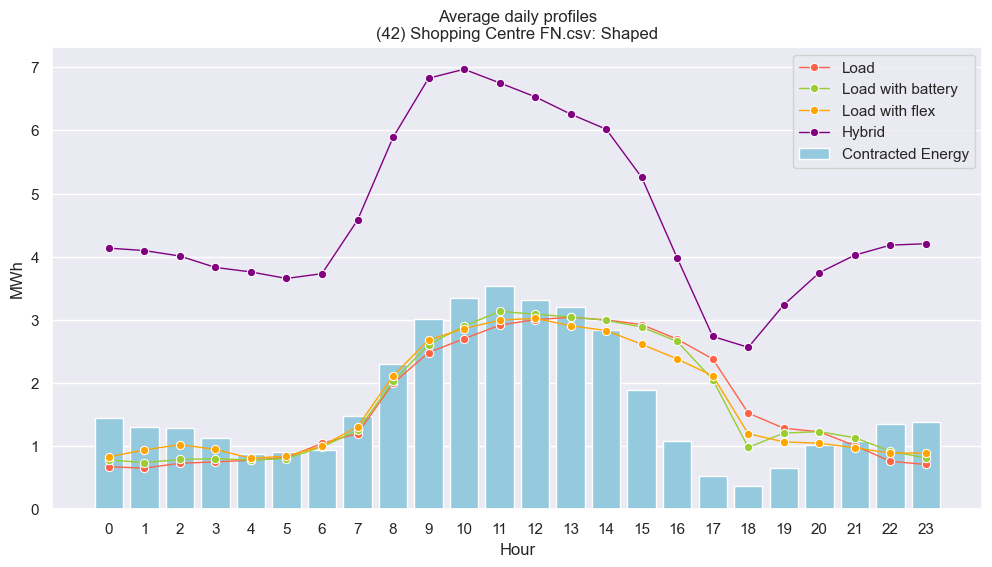

In [27]:
# charts.plot_contract_samples(combined_data,input_collector,['Load', 'Load with battery', 'Load with flex'])
charts.plot_contract_samples(combined_data,input_collector['contract_type'].value,input_collector['load_data_file'].value,['Load', 'Load with battery', 'Load with flex'])


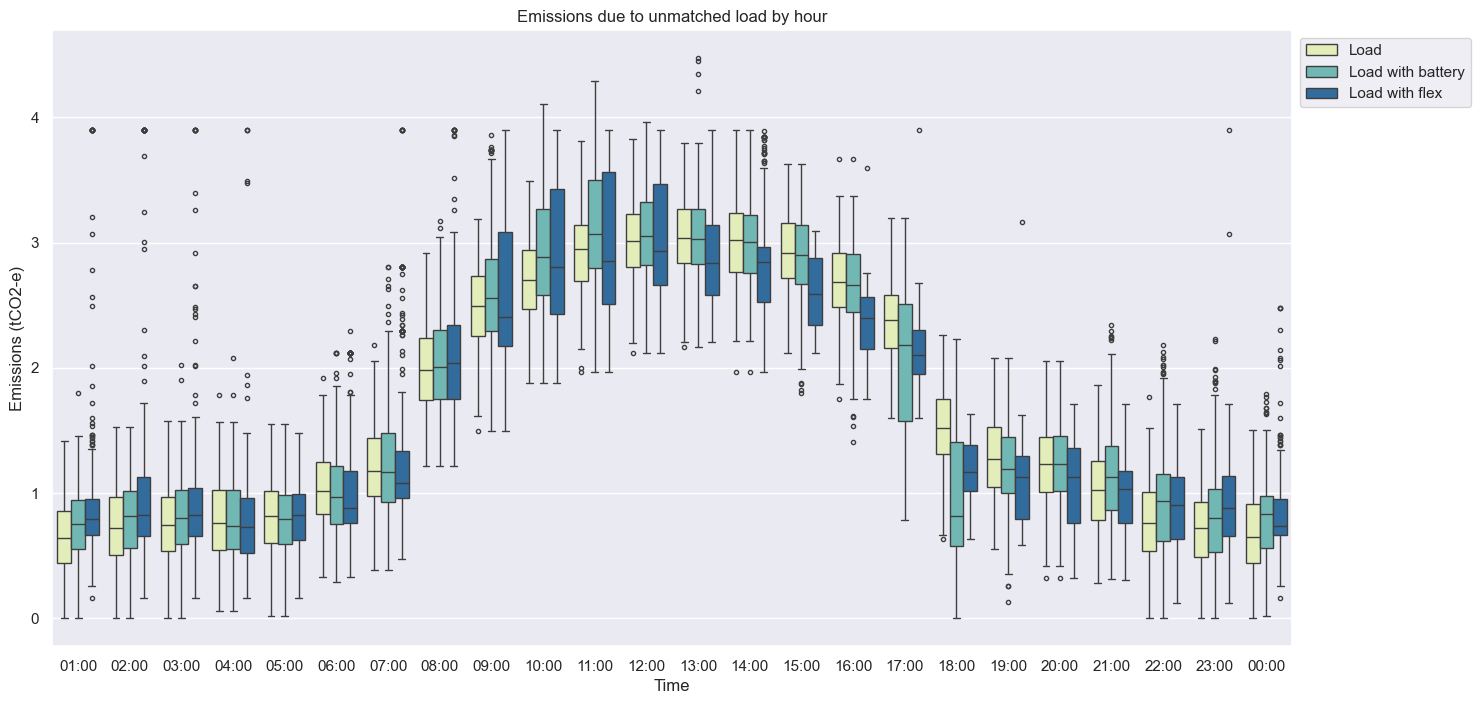

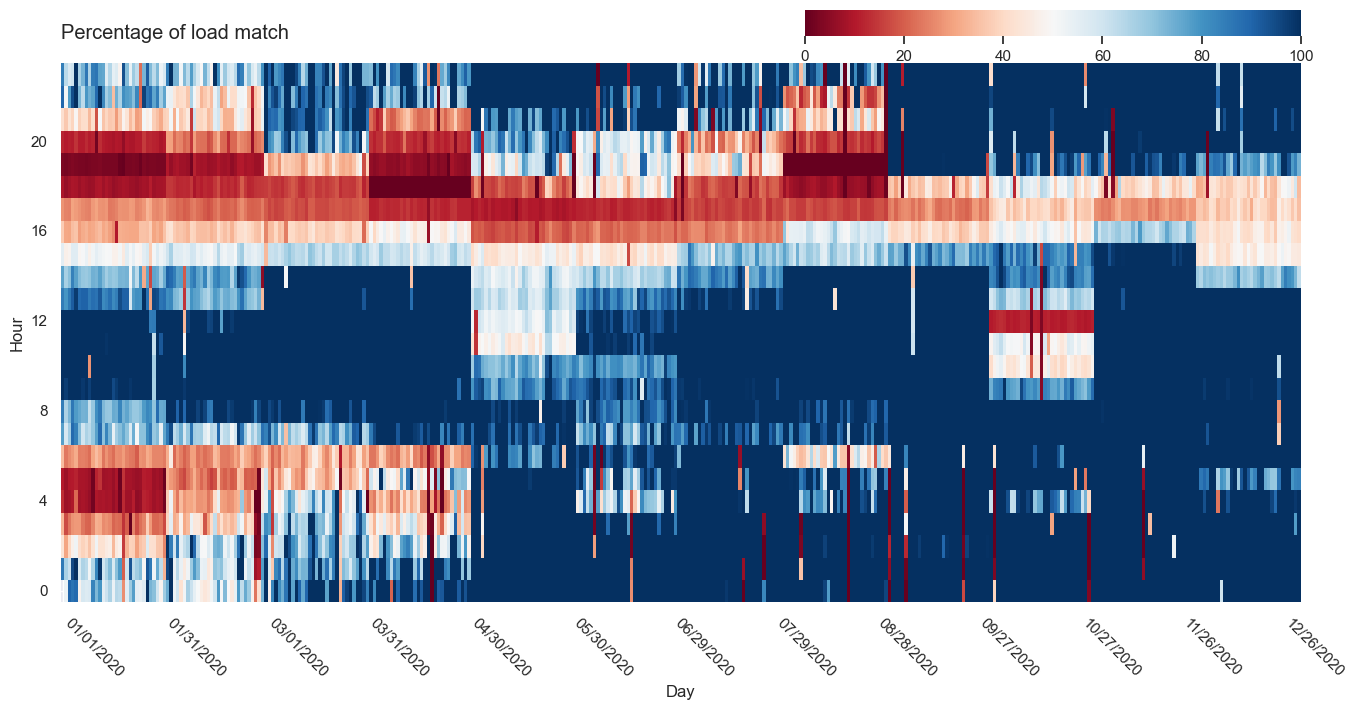

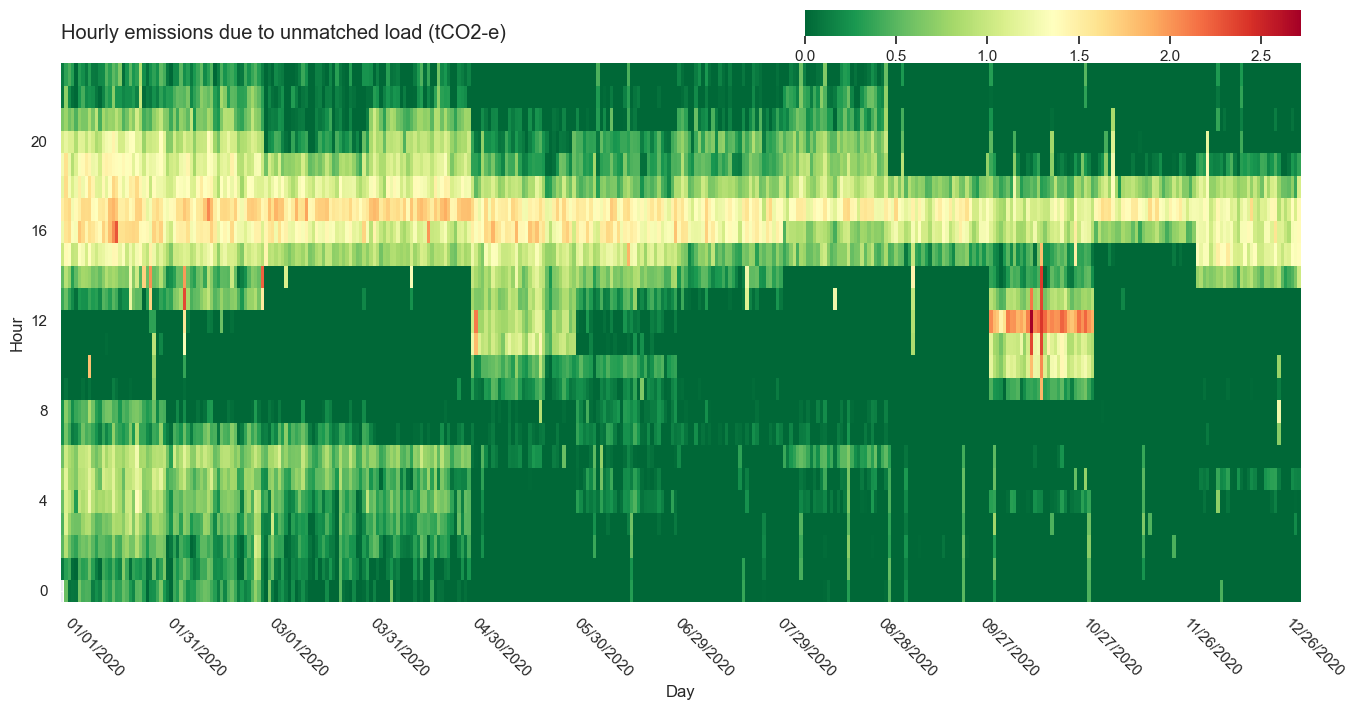

In [35]:
charts.plot_emissions_bw(combined_data)
charts.plot_matching_bw(combined_data)
charts.plot_matching_heatmap(combined_data, 'Load')
charts.plot_emissions_heatmap(combined_data, 'Load')